In [1]:
import cv2
import numpy as np
import json
import os

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from skimage import color
from skimage.feature import hog
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [2]:
# From data generate images for training
def get_training_imgs(size=(64,64)):
    DATA_PATH = './benchmark_velocity_train/clips/'

    for n in range(1,100):
        f = open(DATA_PATH + str(n) + '/annotation.json')
        data = json.load(f)[0]
        f.close()
        
        img = cv2.imread(DATA_PATH + str(n) + '/imgs/040.jpg', 1)
        if img is not None:
            top = int(data['bbox']["top"])
            bottom = int(data['bbox']["bottom"])
            left = int(data['bbox']["left"])
            right = int(data['bbox']["right"])

            p_img = img[top:bottom, left:right]
            p_img = cv2.resize(p_img, size)

            p_img = cv2.normalize(p_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            cv2.imwrite('p_imgs/' + str(n) + '.jpg', p_img*255)
            
            p_img = cv2.flip(p_img, 1)
            cv2.imwrite('p_imgs/' + str(n) + 'flip.jpg', p_img*255)

            for i in range(3):
                i *= 200
                for j in range(4):
                    j *= 300
                    if not (top < i < bottom or top < i + 100 < bottom):
                        if not (left < j < right or left < j + 100 < right):
                            # print(i, j)
                            # print(top, bottom, left, right)
                            n_img = img[i:i+100, j:j+100]
                            n_img = cv2.resize(n_img, size)

                            cv2.imwrite(f'n_imgs/{n}_{i}_{j}.jpg', n_img)

# get_training_imgs()

In [3]:
# Read images of vehicles and non-vehicles and get HOG features
p_imgs = []
n_imgs = []
p_features = []
n_features = []

for filename in os.listdir('p_imgs'):
    img = cv2.imread('p_imgs/' + filename, 1)
    p_imgs.append(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    p_features.append(np.ravel(cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9).compute(img)))

for filename in os.listdir('n_imgs'):
    img = cv2.imread('n_imgs/' + filename, 1)
    n_imgs.append(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    n_features.append(np.ravel(cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9).compute(img)))

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-xeqjxthj\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [4]:
# Train SVC
unscaled_x = np.vstack((p_features, n_features)).astype(np.float64)
scaler = StandardScaler().fit(unscaled_x)

x_scaler = scaler.transform(unscaled_x)
y_scaler = np.hstack((np.ones(len(p_imgs)), np.zeros(len(n_imgs))))

x_train, x_test, y_train, y_test = train_test_split(x_scaler, y_scaler, test_size = 0.2, random_state = np.random.randint(1, 100))
svc = LinearSVC()
svc.fit(x_train, y_train)
svc.score(x_test, y_test)

ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by StandardScaler.

In [19]:
def get_frame(img, x1, x2, y1, y2, overlap, size):   
    xspan = x2 - x1
    yspan = y2 - y1

    nx_pix_per_step = int(size[0]*(1 - overlap[0]))
    ny_pix_per_step = int(size[1]*(1 - overlap[1]))
    nx_windows = int(xspan // nx_pix_per_step)
    ny_windows = int(yspan // ny_pix_per_step)

    frames = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs * nx_pix_per_step + x1
            endx = (xs+1) * nx_pix_per_step + x1
            starty = ys * ny_pix_per_step + y1
            endy = (ys+1) * ny_pix_per_step + y1

            frames.append(((startx, starty), (endx, endy)))
    return frames

In [20]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    out_img = np.copy(img)
    for b in bboxes:
        cv2.rectangle(out_img, *b, color, thick)
    return out_img

In [21]:
def detect_vehicles(img):
    detected_vehicles = []
    step = 8
    
    pxs = 320
    PXS_LIMIT = 720
    ACCEPTANCE_THRESHOLD = .99
    size = (64,64)

    detected_vehicles = []

    while pxs < PXS_LIMIT:
        windows = get_frame(img, 0, img.shape[1], 400, 660, (0.8, 0.8), size)  

        for window in windows:
            features = []
            resized = cv2.resize((img[window[0][1]: window[1][1], window[0][0]: window[1][0]]), size)
            resized = cv2.cvtColor(resized, cv2.COLOR_RGB2YUV)

            hog_features = np.ravel(cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9).compute(resized))
            
            x_scaled = scaler.transform(hog_features.reshape(1, -1))
            
            if resized.shape[0] > 0:
                if svc.predict(x_scaled.reshape(1, -1)) > ACCEPTANCE_THRESHOLD:
                    detected_vehicles.append(window)

        pxs += step
        
    return detected_vehicles

In [ ]:
def test_img(image):
    detected_vehicles = detect_vehicles(image)
        
    out = np.copy(image)
    boxes = draw_boxes(np.zeros_like(image), bboxes=detected_vehicles, thick=-1)
    contours, _ = cv2.findContours(boxes[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for countour in contours:
        rect_color_tup = (0,255,0)
        x, y, width, height = cv2.boundingRect(countour)
        cv2.rectangle(out, (x, y), (x + width, y + height), rect_color_tup, 6)
    
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('original')
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    ax2.axis('off')
    ax2.set_title('car detected box spots')
    ax2.imshow(boxes, cmap='hot')
    ax3.axis('off')
    ax3.set_title('Annotated car')
    ax3.imshow(cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    print('fuck')

for i in range(10, 20):
    img = cv2.imread('./clips/' + str(i) + '/imgs/040.jpg', 1)
    test_img(img)

In [ ]:
ppc = 16

fd, hog_image = hog(p_imgs[80], orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

plt.imshow(hog_image)

In [ ]:
ppc = 16

fd, hog_image = hog(n_imgs[80], orientations=8, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

plt.imshow(hog_image)

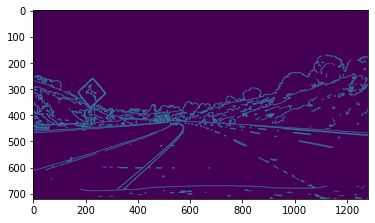

In [95]:
img = cv2.imread('test_images/test2.jpg', 0)
edges = cv2.Canny(img,100,200)

plt.imshow(edges)